In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_ADA-USD.csv')
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Date,Open,High,Low,Price,Adj Close,Volume
0,2018-03-01,0.311973,0.311973,0.288392,0.304397,0.304397,184691008
1,2018-03-02,0.304424,0.307058,0.288875,0.293504,0.293504,107240000
2,2018-03-03,0.292952,0.309129,0.292507,0.297106,0.297106,115320000
3,2018-03-04,0.296285,0.303588,0.286193,0.300787,0.300787,94436000
4,2018-03-05,0.299897,0.317723,0.291055,0.297622,0.297622,202675008


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2285 non-null   datetime64[ns]
 1   Open       2285 non-null   float64       
 2   High       2285 non-null   float64       
 3   Low        2285 non-null   float64       
 4   Price      2285 non-null   float64       
 5   Adj Close  2285 non-null   float64       
 6   Volume     2285 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 125.1 KB


In [4]:
# Thiết lập index
df1=df.reset_index()['Price']


In [5]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# Chia train test
train_size= int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step)]
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)


In [8]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100 _8_2
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, y_test = create_dataset(combined_data, time_step)

# Reshape dữ liệu cho phù hợp với mạng GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
24/24 [==============================] - 5s 10ms/step - loss: 0.0177
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 6.3960e-04
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 5.3953e-04
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 5.1930e-04
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 4.8989e-04
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 4.8426e-04
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 4.7072e-04
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 4.8031e-04
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 4.4528e-04
Epoch 11/100
24/24 [==============================] - 0s 8ms/step - loss: 4.4057e-04
Epoch 12/100
24/24 [==============================] - 0s 8ms/step - loss: 4.3922e

In [13]:
# Dự báo dữ liệu test và train
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

22/22 [==============================] - 0s 4ms/step


In [14]:
# Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [15]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

i = 0
while(i < 90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])  # Lấy từng ngày từ ngày thứ 2 trở đi
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        temp_input = temp_input[1:]  # Loại bỏ ngày đầu tiên
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1
    else:
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1

# In ra dự đoán cho 90 ngày tiếp theo
print("Dự đoán giá cho 90 ngày tiếp theo:")
print(lst_output)

Dự đoán giá cho 90 ngày tiếp theo:
[[0.14193406701087952], [0.13997215032577515], [0.13795103132724762], [0.13594099879264832], [0.13392674922943115], [0.13190260529518127], [0.1298678070306778], [0.12782305479049683], [0.12576934695243835], [0.12370768189430237], [0.1216389536857605], [0.11956389993429184], [0.11748310923576355], [0.11539704352617264], [0.11330604553222656], [0.11121038347482681], [0.10911024361848831], [0.1070057600736618], [0.10489699989557266], [0.10278400778770447], [0.10066680610179901], [0.0985453724861145], [0.09641967713832855], [0.09428966045379639], [0.09215527772903442], [0.0900164395570755], [0.08787307143211365], [0.0857250839471817], [0.0835723802447319], [0.08141486346721649], [0.0792524516582489], [0.07708501815795898], [0.07491245865821838], [0.07273467630147934], [0.0705515593290329], [0.0683630034327507], [0.0661688894033432], [0.06396910548210144], [0.061763547360897064], [0.05955210328102112], [0.05733465403318405], [0.05511108785867691], [0.05288

In [16]:
predict_future_30 = lst_output[:30]
predict_future_60 = lst_output[30:60]
predict_future_90 = lst_output[60:]


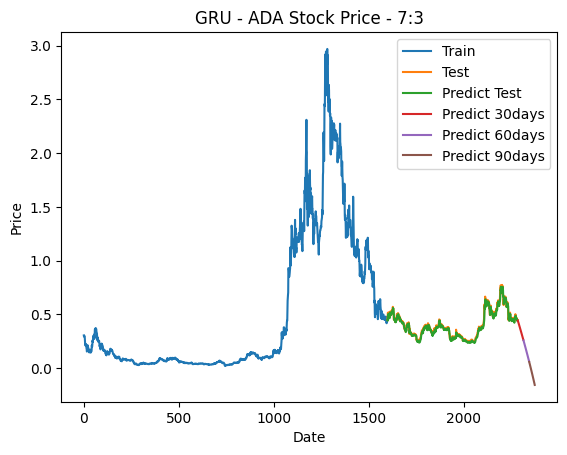

In [18]:
#Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_test_index = pd.RangeIndex(start=train_size, stop=train_size+len(y_pred), step=1)
plt.plot(predicted_test_index, y_pred)

predict_future_30_index = pd.RangeIndex(start=test_data_index[-1]+1, stop=test_data_index[-1]+31, step=1)
plt.plot(predict_future_30_index, scaler.inverse_transform(predict_future_30))

predict_future_60_index = pd.RangeIndex(start=test_data_index[-1]+31, stop=test_data_index[-1]+61, step=1)
plt.plot(predict_future_60_index, scaler.inverse_transform(predict_future_60))

predict_future_90_index = pd.RangeIndex(start=test_data_index[-1]+61, stop=test_data_index[-1]+91, step=1)
plt.plot(predict_future_90_index, scaler.inverse_transform(predict_future_90))

plt.title('GRU - ADA Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Train','Test','Predict Test','Predict 30days','Predict 60days','Predict 90days'])
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.26928916711273027
Mean Absolute Percentage Error (MAPE): 208.38285055774034
Root Mean Square Error (RMSE): 0.28077937281184817


In [ ]:
# # 12. Đánh giá độ chính xác thuật toán bằng RMSE
# test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
# print('Testing RMSE:', test_rmse)
# # Đánh giá độ chính xác thuật toán bằng MAE
# test_mae = np.mean(abs(y_pred - y_test))
# print('Testing MAE:', test_mae)
# # Đánh giá độ chính xác thuật toán bằng MAPE
# test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_pred))
# print('Testing MAPE:', test_mape)

Testing RMSE: 0.30995897321254945
Testing MAE: 0.29635483355720177
Testing MAPE: 0.6935905549176788
